In [1]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from IPython.display import display, HTML, clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)

        return h


class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)


class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, *args):
        return self.upsample(x)


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=64,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=2,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t, c):

        time_emb = self.time_embeddings(t)

        c_emb = self.time_embeddings(c)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb + c_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb + c_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb + c_emb)

        h = self.final(h)

        return h


In [4]:
class Diffusion:
  def __init__(self, timesteps=1000, img_shape=(3, 64, 64), device='cpu'):
    self.timesteps = timesteps
    self.img_shape = img_shape
    self.device = device

    self.initialize()

  def get_betas(self, start=1e-4, end=0.02):
    return torch.linspace(start, end, self.timesteps)

  def initialize(self):
    self.betas = self.get_betas().to(self.device)
    self.alphas = 1 - self.betas

    self.alpha_hat = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
    self.sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat)
    self.one_by_sqrt_alpha = 1. / torch.sqrt(self.alphas)
    self.sqrt_beta = torch.sqrt(self.betas)


def get(x: torch.Tensor, t: torch.Tensor):
  # print(x.get_device(), t.get_device())
  return x.gather(-1, t).reshape(-1, 1, 1, 1)

def forward_diffusion(d: Diffusion, x0: torch.Tensor, t: torch.Tensor):
  eps = torch.randn_like(x0)
  # print(d.alpha_hat.get_device(), x0.get_device(), t.get_device())
  xt = get(d.sqrt_alpha_hat, t) * x0 + get(d.sqrt_one_minus_alpha_hat, t) * eps
  # xt = torch.sqrt(d.alpha_hat[t])[:, None, None, None] * x0 + torch.sqrt(1. - d.alpha_hat[t])[:, None, None, None] * eps
  return xt, eps

In [5]:
def get_data(batch_size=32, num_workers=0, pin_memory=False, device="cpu"):
  transforms = TF.Compose(
        [
            TF.ToTensor(),
            TF.Resize((32, 32),
                      interpolation=TF.InterpolationMode.BICUBIC,
                      antialias=True),
            TF.RandomHorizontalFlip(),
            TF.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
        ]
  )

  dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

  return dataloader

def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

100%|██████████| 170498071/170498071 [00:03<00:00, 48492085.75it/s]


Extracting data/cifar-10-python.tar.gz to data


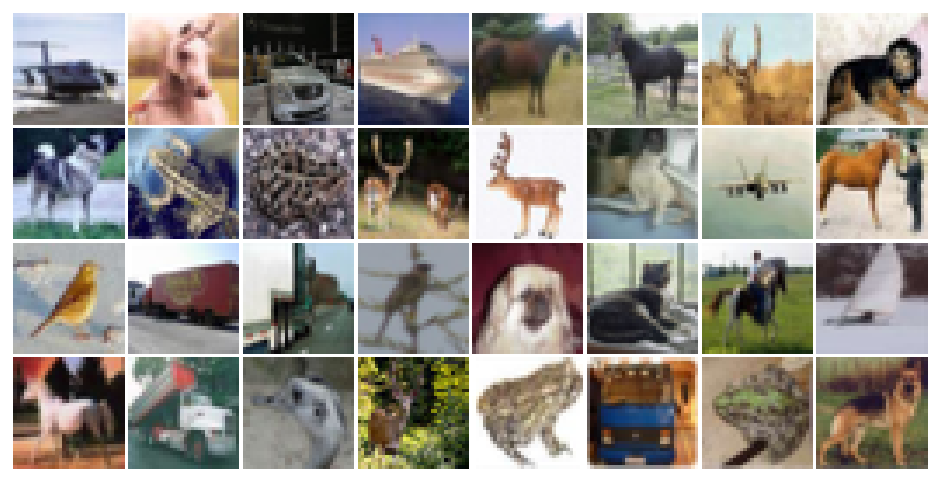

In [6]:
plt.figure(figsize=(12, 6), facecolor='white')
loader = get_data()

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=8, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [12]:
def make_dirs():
  os.makedirs('/content/drive/MyDrive/models', exist_ok=True)
  os.makedirs('/content/drive/MyDrive/images', exist_ok=True)
  # os.makedirs(os.path.join('models' + name), exists_ok=True)
  # os.makedirs(os.path.join('images' + name), exists_ok=True)
make_dirs()

Files already downloaded and verified
tensor([1, 2, 6, 1, 2, 9])


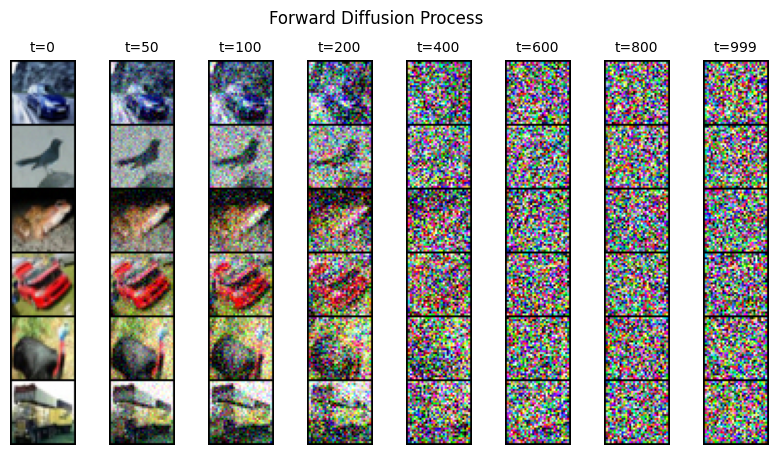

In [7]:
d = Diffusion()

noisy_imgs = []
timesteps = [0, 50, 100, 200, 400, 600, 800, 999]
loader = get_data(6)

for img, c in loader:
  print(c)
  for timestep in timesteps:
    timestep = torch.as_tensor([timestep] * img.shape[0], dtype=torch.long)

    img_with_noise, _ = forward_diffusion(d, img, timestep)
    img_with_noise = inverse_transform(img_with_noise) / 255.
    img_with_noise = make_grid(img_with_noise, nrow=1, padding=1)

    noisy_imgs.append(img_with_noise)
  break

_, ax = plt.subplots(1, len(noisy_imgs), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(timesteps, noisy_imgs)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=10)
    ax[i].axis("off")
    # ax[i].grid(False)

plt.suptitle("Forward Diffusion Process")
plt.axis("off")
plt.show()


In [8]:
!pip install torchmetrics
from torchmetrics import MeanMetric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 13.4 MB/s eta 0:00:00


In [9]:
# Training

def train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, epochs=300, timesteps=1000):
  epoch_loss = MeanMetric()
  model.train()

  with tqdm(total=len(loader), dynamic_ncols=True) as tq:
    tq.set_description(f'Train :: Epoch: {epoch}/{epochs}')

    for x0, class_name in loader:
      tq.update(1)
      x0 = x0.to(device)

      t = torch.randint(low=1, high=timesteps, size=(x0.shape[0],), device=device)
      xt, noise = forward_diffusion(d, x0, t)

      with amp.autocast():
        pred_noise = model(xt, t, class_name.to(device))
        loss = loss_func(noise, pred_noise)

      optimizer.zero_grad(set_to_none=True)
      scaler.scale(loss).backward()

      scaler.step(optimizer)
      scaler.update()

      loss_val = loss.detach().item()

      tq.set_postfix_str(s=f'Loss: {loss_val: .5f}')

      epoch_loss.update(loss_val)

    tq.set_postfix_str(s=f'Epoch loss: {epoch_loss.compute().item()}')

  return epoch_loss

In [ ]:
class_name = torch.randint(0, 10, (15,), device="cpu")
class_name

tensor([8, 4, 1, 2, 8, 9, 5, 3, 0, 3, 2, 8, 1, 3, 4])

In [19]:
# Sampling

@torch.inference_mode()
def sampling(model, d, num_images=32, nrows=8, device="cuda"):
    model.eval()

  # with torch.no_grad():
    x = torch.randn((num_images, *d.img_shape), device=device)
    class_name = torch.randint(0, 10, (num_images,), device=device)
    print(class_name)

    for i in tqdm(reversed(range(1, d.timesteps)), total=d.timesteps-1, dynamic_ncols=False, desc="Sampling :: ", position=0):
        t = (torch.ones(num_images) * i).long().to(device)
        # class_name = torch.randn(num_images, device=device)
        # class_name = torch.randint(0, 10, (num_images,), device=device)
        # print(class_name)

        predicted_noise = model(x, t, class_name)

        one_by_sqrt_alpha_t = get(d.one_by_sqrt_alpha, t)
        sqrt_one_minus_alpha_hat_t = get(d.sqrt_one_minus_alpha_hat, t)
        sqrt_beta_t = get(d.sqrt_beta, t)
        beta_t = get(d.betas, t)

        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = one_by_sqrt_alpha_t * (x - (beta_t / sqrt_one_minus_alpha_hat_t) * predicted_noise) + sqrt_beta_t * noise

    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x


In [11]:
model = UNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

loader = get_data(batch_size=128, num_workers=2, pin_memory=True, device=device)

d = Diffusion(device=device)
scaler = amp.GradScaler()
epochs = 100

Files already downloaded and verified


In [12]:
def save_images(images, path, **kwargs):
  grid = torchvision.utils.make_grid(images, **kwargs)
  ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
  im = Image.fromarray(ndarr)
  im.save(path)

In [ ]:
for epoch in range(1, epochs + 1):
  torch.cuda.empty_cache()
  gc.collect()

  train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, epochs)
  if epoch % 5 == 0:
    res = sampling(model, d)

    checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
    }

    torch.save(checkpoint_dict, os.path.join("/content/drive/MyDrive/models", f"{epoch}ckpt.tar"))
    del checkpoint_dict

    save_images(res, os.path.join("/content/drive/MyDrive/images", f"{epoch}.jpg"))



Train :: Epoch: 84/100:  30%|██▉       | 116/391 [00:35<01:22,  3.33it/s, Loss:  0.02956]

In [36]:
model = UNet()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scaler = amp.GradScaler()

checkpoint = torch.load('/content/drive/MyDrive/models/80ckpt.tar')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['opt'])
scaler.load_state_dict(checkpoint['scaler'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.train()

UNet(
  (time_embeddings): SinusoidalPositionEmbeddings(
    (time_blocks): Sequential(
      (0): Embedding(1000, 64)
      (1): Linear(in_features=64, out_features=128, bias=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (encoder_blocks): ModuleList(
    (0-1): 2 x ResnetBlock(
      (act_fn): SiLU()
      (normlize_1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (dense_1): Linear(in_features=128, out_features=64, bias=True)
      (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
      (dropout): Dropout2d(p=0.1, inplace=False)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (match_input): Identity()
      (attention): Identity()
    )
    (2): DownSample(
      (downsample): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1

In [33]:
res = sampling(model, d, num_images=1)
save_images(res, '/content/res.jpg')

tensor([3], device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:15<00:00, 63.64it/s]


In [ ]:
for epoch in range(11, 21):
  torch.cuda.empty_cache()
  gc.collect()

  train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, 20)
  if epoch % 5 == 0:
    res = sampling(model, d)

    checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
    }

    torch.save(checkpoint_dict, os.path.join("/content/", f"{epoch}ckpt.tar"))
    del checkpoint_dict

    save_images(res, os.path.join("/content/", f"{epoch}.jpg"))


Train :: Epoch: 15/20: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s, Epoch loss: 0.02957567200064659]


tensor([9, 7, 2, 6, 5, 7, 9, 8, 0, 4, 7, 8, 0, 6, 9, 6, 4, 3, 5, 4, 9, 7, 5, 6,
        7, 6, 4, 6, 4, 5, 8, 2], device='cuda:0')


Train :: Epoch: 19/20:  25%|██▌       | 99/391 [00:29<01:26,  3.36it/s, Loss:  0.02655]